## Compare location data to schedule

## Imports

In [1]:
import warnings
from datetime import datetime
from pathlib import Path

import gtfs_kit as gk
import pandas as pd
from google.transit.gtfs_realtime_pb2 import FeedMessage

## General settings

In [2]:
rid = "3815"
pb2_path = Path("../data")
sched_path = "../data/itm_south_east_gtfs.zip"

## Load pb2 data

In [3]:
trips = []
for f in sorted(pb2_path.glob("*.pb2")):
    msg = FeedMessage()
    msg.ParseFromString(f.read_bytes())
    for t in msg.entity:
        if t.vehicle.trip.route_id == "3815":
            trips.append(t)

In [4]:
# 1 == STOPPED_AT
# 2 == IN_TRANSIT_TO
rows = [
    {
        "id": t.id,
        "trip_id": t.vehicle.trip.trip_id,
        "route_id": t.vehicle.trip.route_id,
        "start_time": t.vehicle.trip.start_time,
        "start_date": t.vehicle.trip.start_date,
        "latitude": t.vehicle.position.latitude,
        "longitude": t.vehicle.position.longitude,
        "current_stop": t.vehicle.current_stop_sequence,
        "current_status": t.vehicle.current_status,
        "timestamp": datetime.utcfromtimestamp(t.vehicle.timestamp),
        "vehicle": t.vehicle.vehicle.id,
    }
    for t in trips
]
df = pd.DataFrame(rows).drop_duplicates()
df.timestamp = df.timestamp.dt.tz_localize("UTC")
df.head()

,id,trip_id,route_id,start_time,start_date,latitude,longitude,current_stop,current_status,timestamp,vehicle
0,8931724906858233862,VJbf1af309850819f0c13270b1c82a48b16c1448bf,3815,16:34:00,20221015,51.753353,-1.269630,0,1,2022-10-15 16:37:37+00:00,SCOX-10439
1,9393660296727820281,VJ4453880e00c6b8699902fa03cd32d0b0e4f5bb82,3815,15:28:00,20221015,51.753132,-1.269510,34,2,2022-10-15 16:37:29+00:00,SCOX-10670
2,13198027651868249401,VJa3cf6467349c7ca904f66eb783c6a2a7ce0efc1c,3815,16:14:00,20221015,51.742176,-1.225982,11,2,2022-10-15 16:37:29+00:00,SCOX-10786
3,12588706537461538842,VJ468e537bf6dd2059cdbdfd4034adb36d63854792,3815,15:48:00,20221015,51.752750,-1.268950,34,2,2022-10-15 16:37:43+00:00,SCOX-15762
4,45600219776146125,VJ1c088dffb53757281e41073dc2a86fc8df042f42,3815,15:58:00,20221015,51.741722,-1.225518,23,2,2022-10-15 16:37:50+00:00,SCOX-10438


In [5]:
tid = df.sort_values(by=["current_stop", "start_time"], ascending=False).iloc[0].trip_id
tid

'VJ995095b11ef56e66beb70668d04022b166e1b98b'

### TODO
This gets the first instance of each current_stop
and uses that timestamp, but this is wrong!

Should actually:
1. If `current_status==` (stopped), then do something else
2. Use the _first_ instance of each stop as the time for departure of the stop before
3. Use the _last_ instance of each stop as the time for arrival of the stop after

In [6]:
actual = df.loc[df.trip_id == tid].drop_duplicates(
    subset=["current_stop"], keep="first"
)[["current_stop", "timestamp"]]
print(len(actual))
actual.head()

33


,current_stop,timestamp
1993,0,2022-10-15 17:23:26+00:00
2007,2,2022-10-15 17:24:07+00:00
2056,3,2022-10-15 17:25:07+00:00
2119,4,2022-10-15 17:26:29+00:00
2179,5,2022-10-15 17:28:11+00:00


## Load schedule feed

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fd = gk.read_feed(sched_path, dist_units="mi")

In [8]:
def fix_dt(col: pd.Series, actual: pd.DataFrame):
    date = actual.iloc[0].timestamp.strftime("%Y-%m-%d")
    return (
        pd.to_datetime(date + "T" + col)
        .dt.tz_localize("Europe/London")
        .dt.tz_convert("UTC")
    )

In [9]:
fd.trips.loc[fd.trips.trip_id == tid]

,route_id,service_id,trip_id,trip_headsign,block_id,shape_id,wheelchair_accessible,trip_direction_name,vehicle_journey_code
63696,3815,1059,VJ995095b11ef56e66beb70668d04022b166e1b98b,Oxford City Centre,75fb734d26dd55f05be65ded82a65585920977b4,RPSP4199039561736d882e8c165292bcd65aa4a3d434,0,NaN,VJ660


In [10]:
sched = fd.stop_times.loc[fd.stop_times.trip_id == tid][
    ["arrival_time", "departure_time", "stop_id", "stop_sequence"]
]
sched.arrival_time = fix_dt(sched.arrival_time, actual)
sched.departure_time = fix_dt(sched.departure_time, actual)
print(len(sched))
sched.head()

35


,arrival_time,departure_time,stop_id,stop_sequence
2273818,2022-10-15 17:18:00+00:00,2022-10-15 17:18:00+00:00,340001230ERB,0
2273819,2022-10-15 17:18:38+00:00,2022-10-15 17:18:38+00:00,340001219CNR,1
2273820,2022-10-15 17:19:16+00:00,2022-10-15 17:19:16+00:00,340001234CNR,2
2273821,2022-10-15 17:20:34+00:00,2022-10-15 17:20:34+00:00,340001229CNR,3
2273822,2022-10-15 17:22:00+00:00,2022-10-15 17:25:00+00:00,340001224CNR,4


## Join and compare times

In [11]:
comp = sched.merge(actual, left_on="stop_sequence", right_on="current_stop")[
    ["stop_id", "stop_sequence", "arrival_time", "timestamp"]
]
comp = comp.assign(delay=(comp.timestamp - comp.arrival_time).astype("timedelta64[s]"))
comp

,stop_id,stop_sequence,arrival_time,timestamp,delay
0,340001230ERB,0,2022-10-15 17:18:00+00:00,2022-10-15 17:23:26+00:00,326.0
1,340001234CNR,2,2022-10-15 17:19:16+00:00,2022-10-15 17:24:07+00:00,291.0
2,340001229CNR,3,2022-10-15 17:20:34+00:00,2022-10-15 17:25:07+00:00,273.0
3,340001224CNR,4,2022-10-15 17:22:00+00:00,2022-10-15 17:26:29+00:00,269.0
4,340001231CNR,5,2022-10-15 17:26:00+00:00,2022-10-15 17:28:11+00:00,131.0
5,340001227CNM,6,2022-10-15 17:26:28+00:00,2022-10-15 17:34:16+00:00,468.0
6,340001223CNR,7,2022-10-15 17:26:53+00:00,2022-10-15 17:35:17+00:00,504.0
7,340001222CNR,8,2022-10-15 17:27:21+00:00,2022-10-15 17:35:38+00:00,497.0
8,340001218CNR,9,2022-10-15 17:27:58+00:00,2022-10-15 17:35:58+00:00,480.0
9,340001220OPP,10,2022-10-15 17:28:19+00:00,2022-10-15 17:36:39+00:00,500.0


<AxesSubplot: >

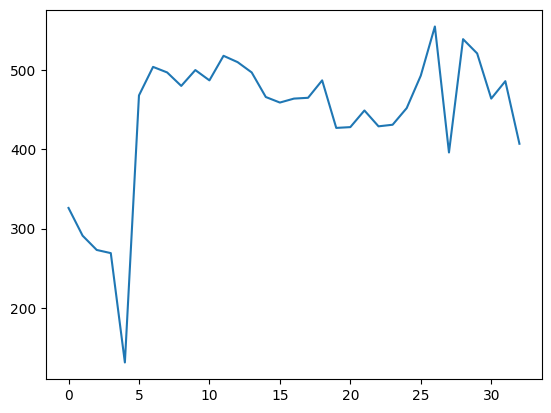

In [12]:
comp.delay.plot()

<AxesSubplot: >

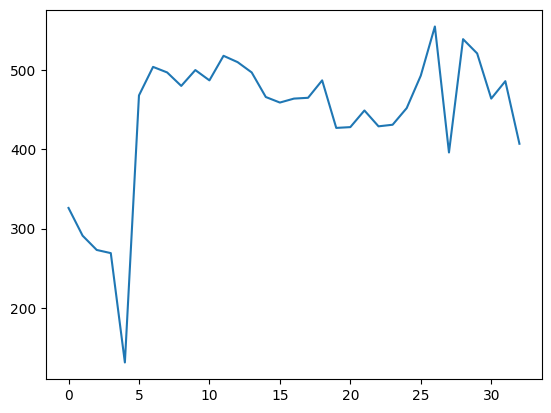

In [13]:
comp.delay.plot()

In [14]:
fd.stop_times[
    (fd.stop_times.trip_id == tid) & (fd.stop_times.stop_sequence.isin([4, 5, 6]))
]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_direction_name
2273822,VJ995095b11ef56e66beb70668d04022b166e1b98b,18:22:00,18:25:00,340001224CNR,4,NaN,0,0,1.20366,1,NaN
2273823,VJ995095b11ef56e66beb70668d04022b166e1b98b,18:26:00,18:26:00,340001231CNR,5,NaN,0,0,1.61612,0,NaN
2273824,VJ995095b11ef56e66beb70668d04022b166e1b98b,18:26:28,18:26:28,340001227CNM,6,NaN,0,0,1.80121,0,NaN


In [15]:
warnings.simplefilter("ignore")
fd.map_routes([rid], include_stops=True)